In [3]:
import requests
import yfinance as yf
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pprint import pprint
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [24]:
# Foreground styling
def return_styling_fg(col_):
    colors = ['#b90e0a' if val < 0 else '#028a0f' for val in col_] # Set positive returns as green and negative as red
    colors = ['color: {}'.format(color) for color in colors]
    return colors
# Background styling
def return_styling_bg(col_):
    colors = ['white' for val in col_]
    colors = ['background-color: {}'.format(color) for color in colors]
    return colors
# Return dates in a format the API understands (%Y-%m-%d)
def get_dates(start_=None, end_=None):
    if start_:
        start_ = dt.datetime.strptime(start_, '%m/%d/%Y').strftime('%Y-%m-%d') # Convert format
    if end_.lower() == "now":
        end_ = dt.date.today() # Returns today's date
    else:
        end_ = dt.datetime.strptime(end_, '%m/%d/%Y')
        end_ = end_ + dt.timedelta(days=1) # The end date is exclusive so one day is added to include it
        end_ = end_.strftime('%Y-%m-%d')
    return start_, end_
# Gets a ticker's returns between the specified dates
def get_ticker_return(ticker_, start_, end_):
    ticker_obj_ = yf.Ticker(ticker_)
    start_, end_ = get_dates(start_, end_)
    ticker_hist = ticker_obj_.history(start=start_, end=end_)
    ticker_hist = ticker_hist["Close"] # Returns only the closing prices
    ticker_returns = pd.Series(index=ticker_hist.index, name=ticker_, dtype=float)
    index_ = 0
    for price_ in ticker_hist[index_:]: # Computes every day's total return
        ticker_returns.iloc[index_] = ((price_ - ticker_hist.iloc[0]) / ticker_hist.iloc[0]) * 100
        index_ += 1
    return ticker_returns.to_frame()
# Iniitialize graph parameters
def graph_():
    plt.rcParams['figure.facecolor'] = 'white'
    fig, ax = plt.subplots(figsize=(30, 10))
    plt.xticks(rotation=70)
    return fig, ax
# Plot graph
def plotting(returns_):
    fig, ax = graph_()
    if returns_.shape[1] == 1: # For a single column dataframe, print one line
        sns.lineplot(x=returns_.index, y=returns_.iloc[:,0], ax=ax)
    else:
        for col_ in returns_.columns: # Print one line per column
            sns.lineplot(x=returns_.index, y=returns_[col_], label=col_, ax=ax)
    ax.set_title("Performance", fontsize=22)
    ax.set_ylabel("Return (%)", fontsize=16)
    ax.set_xlabel("Date", fontsize=16)
    handles, labels = ax.get_legend_handles_labels()
    for label in labels:
        labels[labels.index(label)] = f'{label}: {round(returns_[label][-1], 2)}%' # Add the final return to the legend for easy comparison
    ax.legend(handles=handles, labels=labels)
    plt.setp(ax.get_legend().get_texts(), fontsize='14')


In [17]:
# Return all stocks within the specified index (limited to dowjones, sp500, nasdaq100)
def get_index_(index):
    sp500_ = requests.get(f'https://www.slickcharts.com/{index}')
    sp500_bs_ = BeautifulSoup(sp500_.content, 'html.parser')
    sp500_ = sp500_bs_.tbody
    sp500_ = [stock_ for stock_ in sp500_.children if not str(stock_) in ['\n', '<br/>']]
    stocks_list = []
    for stock_ in sp500_:
        stock_con_ = [con_ for con_ in stock_.contents if not str(con_) in ['\n', '<br/>']]
        stocks_list.append(stock_con_[2].get_text())
    return stocks_list
# Returns stocks that outperformed the index
def outperforming_index(index_stocks, index_, start_, end_, max_outperformers=3):
    index_returns = get_ticker_return(index_, start_, end_)
    tickers_outperform = index_returns
    for ticker_ in index_stocks: # Returns for all stocks passed
        stock_returns = get_ticker_return(ticker_, start_, end_)
        if stock_returns.empty: # Ignore stocks with no data
            continue
        if (stock_returns.iloc[-1, 0] > index_returns.iloc[-1, 0]): # Stocks with returns greater than that of the index
            tickers_outperform = pd.concat([tickers_outperform, stock_returns], axis=1, join="inner")
    tickers_outperform_names = list(tickers_outperform.iloc[-1, 1:].sort_values(ascending=False).index[:max_outperformers])
    tickers_outperform_names.append(index_)
    tickers_outperform = tickers_outperform[tickers_outperform_names]
    display(tickers_outperform.astype(float).round(2).style.apply(return_styling_fg, axis=0))
    if not tickers_outperform.shape[1] >= 20: # No graph if 20 or more stocks outperforming the index
        plotting(tickers_outperform)
    return tickers_outperform

In [18]:
# Returns sector returns over time periods
def get_sector_returns():
    sectors_df = pd.DataFrame()
    sectors_ = requests.get('https://eresearch.fidelity.com/eresearch/markets_sectors/sectors/si_performance.jhtml?tab=siperformance')
    sectors_bs_ = BeautifulSoup(sectors_.content, 'html.parser')
    sectors_table = sectors_bs_.tbody
    sectors_table = [sector_ for sector_ in sectors_table.children if not str(sector_) in ['\n', '<br/>']]
    for sector in sectors_table:
        sector_con_ = [con_ for con_ in sector.contents if not str(con_) in ['\n', '<br/>']]
        row_info = []
        for return_ in sector_con_[1:]:
            row_info.append(return_['cvalue'])
        sector_row = pd.Series(data=row_info, name=sector_con_[0]['cvalue'])
        sectors_df = sectors_df.append(sector_row)
    sectors_df.columns = ["Last", "1_Day", "5_Day", "1_Month", "3_Month", "YTD", "1_Year", "3_Year", "5_Year", "10_Year"]
    sectors_df = sectors_df.replace({'--': '0'})
    display(sectors_df.astype(float).round(2).style.apply(return_styling_fg, axis=0))
    return sectors_df

In [19]:
def fidelity_mutual_funds():
    domestic = pd.DataFrame()
    fide_mf = requests.get('https://www.fidelity.com/mutual-funds/fidelity-funds/overview?selectTab=0')
    fide_mf = BeautifulSoup(fide_mf.content, 'html.parser')
    sectors_table = fide_mf.tbody
    sectors_table = [sector_ for sector_ in sectors_table.children if not str(sector_) in ['\n', '<br/>']]
    for sector in sectors_table:
        sector_con_ = [con_ for con_ in sector.contents if not str(con_) in ['\n', '<br/>']]
        row_info = []
        for return_ in sector_con_[1:]:
            row_info.append(return_['cvalue'])
        sector_row = pd.Series(data=row_info, name=sector_con_[0]['cvalue'])
        sectors_df = sectors_df.append(sector_row)
    sectors_df.columns = ["Last", "1_Day", "5_Day", "1_Month", "3_Month", "YTD", "1_Year", "3_Year", "5_Year", "10_Year"]
    sectors_df = sectors_df.replace({'--': '0'})
    display(sectors_df.astype(float).round(2).style.apply(return_styling_fg, axis=0))
    return sectors_df

In [27]:
# Pipeline for getting stock returns
def pipeline(tickers_, start_, end_):
    if isinstance(tickers_, str):
        returns_ = get_ticker_return(tickers_, start_, end_) # For a single ticker
    else:
        returns_ = get_ticker_return(tickers_[0], start_, end_) # For a list of tickers
        for ticker in tickers_[1:]:
            returns_ = pd.concat([returns_, get_ticker_return(ticker, start_, end_)], axis=1, join="inner")
    returns_ = returns_.astype(float).round(2)
    plotting(returns_)
    display(returns_[:10].style.apply(return_styling_fg, axis=0))
    return returns_

,AAL,UAL,LUV,DAL,SPY
Date,,,,,
2019-06-12 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-13 00:00:00,6.400000,3.960000,3.080000,1.910000,0.410000
2019-06-14 00:00:00,5.070000,3.970000,1.990000,0.960000,0.300000
2019-06-17 00:00:00,4.680000,3.560000,0.740000,0.390000,0.340000
2019-06-18 00:00:00,4.550000,4.310000,1.750000,1.030000,1.390000
2019-06-19 00:00:00,6.790000,5.810000,1.370000,1.640000,1.620000
2019-06-20 00:00:00,3.380000,4.000000,1.390000,0.920000,2.590000
2019-06-21 00:00:00,1.490000,3.500000,0.880000,0.960000,2.440000
2019-06-24 00:00:00,2.310000,3.290000,0.820000,1.100000,2.310000


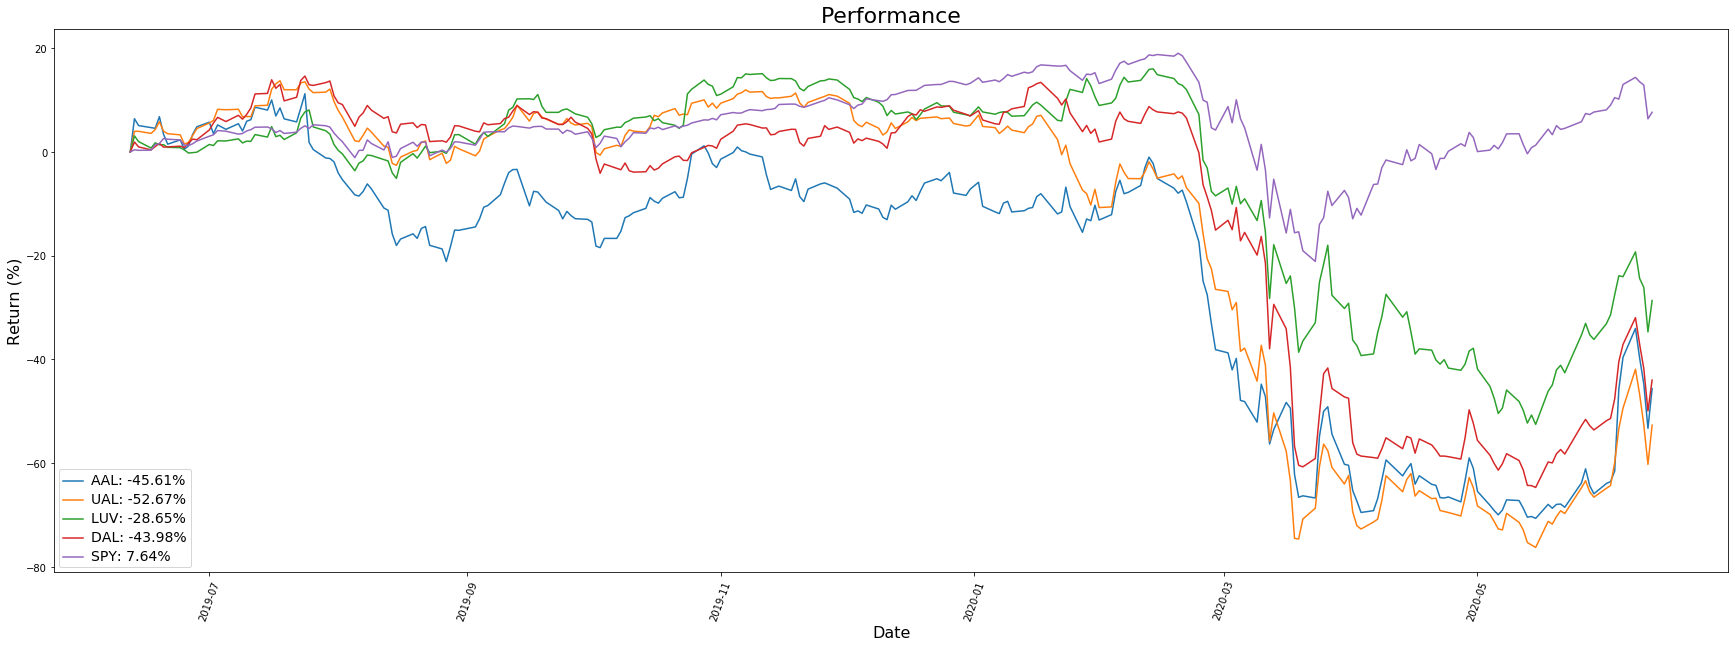

In [28]:
start_ = "6/12/2019"
end_ = "6/12/2020"
tickers_ = ['AAL', 'UAL', 'LUV', 'DAL', 'SPY']
_ = pipeline(tickers_, start_, end_)

#dow30_ = get_index_("dowjones")
#sp500_ = get_index_("sp500")
#nasdaq100_ = get_index_("nasdaq100")
#sector_returns_ = get_sector_returns()

#index_ = "^IXIC"
#_ = outperforming_index(nasdaq100_, index_, start_, end_, 10)

